In [1]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import numpy as np
from scipy import stats
import re


# Gather

## Gather 1st dataframe

In [2]:
#read the provided csv file
df = pd.read_csv('twitter-archive-enhanced.csv')

## Gather data source 2

In [162]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)



1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

KeyboardInterrupt: 

In [3]:
#read json data into a pandas dataframe, importing with lines = True
raw_info = pd.read_json('tweet-json.txt', lines=True, encoding="utf8")
raw_info.shape[0]

2354

In [4]:
#get a dataframe with the required data to avoid large dataframes
tweet_counts = pd.DataFrame()
tweet_counts['retweet_count'] = raw_info['retweet_count']
tweet_counts['favorite_count'] = raw_info['favorite_count']
tweet_counts['tweet_id'] = raw_info['id_str']
#convert id to str, as they are unique identifier
tweet_counts['tweet_id'] = tweet_counts['tweet_id'].apply(lambda x: str(x))
tweet_counts.shape[0]

2354

## Gather data source 3

In [59]:
#get the image predictors tsv file directly from url, as a pd dataframe
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
images = pd.read_csv(url, sep = '\t')
images.shape[0] #check this looks good
images.to_csv('image_predictions.tsv', sep="\t", index = False)#save it locally

# Assess
#### Visual assesment

In [6]:
df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2076,670838202509447168,NaN,NaN,2015-11-29 05:34:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pink dogs here. Unreasonably long necks. Left ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670838202...,4,10,None,None,None,None,None
1313,706904523814649856,NaN,NaN,2016-03-07 18:09:06 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Ever seen a dog pet another dog? Both 13/10 tr...,NaN,NaN,NaN,https://vine.co/v/iXQAm5Lrgrh,13,10,None,None,None,None,None
268,841439858740625411,NaN,NaN,2017-03-14 00:04:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have some incredible doggos for #K9Vet...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/841439858...,14,10,None,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
703,785927819176054784,NaN,NaN,2016-10-11 19:39:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She's strives to be the best pot...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785927819...,12,10,Lucy,None,None,None,None


In [7]:
images.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
782,690005060500217858,https://pbs.twimg.com/media/CZNj8N-WQAMXASZ.jpg,1,Samoyed,0.270287,True,Great_Pyrenees,0.114027,True,teddy,0.072475,False
1761,826115272272650244,https://pbs.twimg.com/media/C3bzVILWcAUjS5i.jpg,1,tennis_ball,0.997071,False,golden_retriever,0.002331,True,kuvasz,0.000283,True
1046,713175907180089344,https://pbs.twimg.com/media/CeW1tERWAAAA9Q2.jpg,1,timber_wolf,0.503788,False,malamute,0.430624,True,Siberian_husky,0.028454,True
1908,852672615818899456,https://pbs.twimg.com/media/C9VNNp1XkAEWRFb.jpg,1,golden_retriever,0.711235,True,otterhound,0.068235,True,Sussex_spaniel,0.046562,True
1403,769212283578875904,https://pbs.twimg.com/media/CqzKfQgXEAAWIY-.jpg,1,golden_retriever,0.166538,True,Pekinese,0.148215,True,cocker_spaniel,0.082735,True


In [8]:
tweet_counts.sample(5)

,retweet_count,favorite_count,tweet_id
589,3227,11065,799297110730567680
1276,745,1941,708853462201716736
1233,1367,4531,712668654853337088
1064,888,3101,740699697422163968
539,2752,11363,806542213899489280


#### Programmatic  assesment

In [9]:
images.info() #tweet id as int64 instead of object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
df.info() #tweet_id as int, Null in expanded_urls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
images.jpg_url.duplicated().sum() #duplicated jpg_url

66

In [12]:
df[df.name.apply(lambda x: x[0].islower())] #names starting with lowercase seems like its a misktake 'such' 'a', etc

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None


In [13]:
df.rating_numerator.value_counts() #several outliers (960,666, etc)

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [14]:
df.rating_denominator.value_counts() #several outliers (960,666, etc)

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Quality (limited to 8 issues)
##### `image_predictions` table
- id code is a float not a string
- upper and lower letters in dog names
- duplicated rows (same picture analysis) (but not twitter ids)

##### `twitter-archive-table` table
- lower case names seems like errors, changing to None
- rating denominator can not be 0, as the division with the rating_numerator would be infinite
- id is a float not a string
- source format not easy to reads
- Outliers in rating_numerator,several ones are to big compared with the rest of them

#### Tidiness
- doggo floofer pupper puppo cathegory should be in just one column
- twitter statistics (tweet_counts df) should be included in tweet statistics. Also predictions for dog (p1) shuld be included in the same dataframe for simplicity when later on plotting results

# Clean
Create newdataframes to clean with function .copy()


In [15]:
image_clean = images.copy()
twarchive_clean= df.copy()

##### `image_predictions` table
- id code is a float not a string
##### Define
redefine id as string.
#### Code:

In [16]:
image_clean['tweet_id'] = images['tweet_id'].apply(lambda x: str(x))

   #### Test:

In [17]:
image_clean['tweet_id'].dtype #object to confirm is string (in pandas strings are saved as objects

dtype('O')

##### `image_predictions` table
- upper and lower letters in dog names
##### Define
to unify dog names all with lower letters.
#### Code:

In [18]:
image_clean.p1 = images.p1.apply(lambda x: x.lower())
image_clean.p2 = images.p2.apply(lambda x: x.lower())
image_clean.p3 = images.p3.apply(lambda x: x.lower())

   #### Test:

In [19]:
image_clean.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


##### `image_predictions` table
- duplicated rows (but not twitter ids)
##### Define
We could obseve duplicated pictures using "images.jpg_url.duplicated().sum()". We attemp to remove duplicated rows. for simplicity we keep the first twitter id. 
#### Code:

In [20]:
image_clean = image_clean[image_clean.drop('tweet_id', axis = 1).duplicated() == False]

#### Check:

In [21]:
image_clean.jpg_url.duplicated().sum() # 0 if duplicated rows have been eliminated

0

##### `twitter-archive-table` table
- lower case names seems like errors, changing to None
##### Define
When we look for names that start with lower case (df[df.name.apply(lambda x: x[0].islower())]) looks like the gathering of the data was not succesfull. To avoid mistakes, we will change the names to 'None'

In [22]:
def lowercasenames(x):
    if x[0].islower():
        x = 'None'
        return x
    else:
        return x

twarchive_clean.name = twarchive_clean.name.apply(lambda x: lowercasenames(x))

##### Test

In [23]:
twarchive_clean[twarchive_clean.name.apply(lambda x: x[0].islower())].shape[0] #0 expected if code worked

0

##### `twitter-archive-table` table
- Outliers in rating_numerator,several ones are to big compared with the rest of them
##### Define
Seems like there were some errors at retriving the rating numerators, as they seems excessive. Based on the standard deviation, we will remove likely outliers from our database. The cutoff for that is a value greater than 2 in the absolute Zscore value. 

In [24]:
z_scores = stats.zscore(twarchive_clean.rating_numerator)
z_scores = np.abs(z_scores)
sum(z_scores > 2) # 11 outliers found with Z-score higher than 3
twarchive_clean = twarchive_clean[z_scores < 2]

In [25]:
sum(z_scores < 2)

2345

##### Test

In [26]:
twarchive_clean.rating_numerator.value_counts() #11 values were removed

12    558
11    464
10    461
13    351
9     158
8     102
7      55
14     54
5      37
6      32
3      19
4      17
2       9
1       9
75      2
0       2
15      2
24      1
20      1
99      1
26      1
44      1
50      1
60      1
84      1
88      1
17      1
27      1
45      1
80      1
Name: rating_numerator, dtype: int64

##### `twitter-archive-table` table
- rating denominator can not be 0, as it is not possible to divide by it. 
##### Define
Denominator = 0 its mathematicaly not possible, for simplicity we will remove the whole row

In [27]:
twarchive_clean = twarchive_clean[twarchive_clean.rating_denominator != 0]

##### test

In [28]:
sum(twarchive_clean.rating_denominator == 0)

0

##### `twitter-archive-table` table
- id is a float not a string
##### Define
change the type of id to string as it shpuld be unique

In [29]:
twarchive_clean['tweet_id'] = twarchive_clean['tweet_id'].apply(lambda x: str(x))

#### Test

In [30]:
twarchive_clean['tweet_id'].dtype #object to confirm is string (in pandas strings are saved as objects

dtype('O')

##### `twitter-archive-table` table
- source format not easy to read
##### Define
get just the url as source.
#### Code:

In [31]:
def searchurl(a):
    inicio = a.find('"')+1
    fin = a.find('"', inicio)
    return a[inicio:fin]
twarchive_clean.source = twarchive_clean.source.apply(lambda x: searchurl(x))

#### Test:

In [32]:
twarchive_clean.sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1137,728046963732717569,NaN,NaN,2016-05-05 02:21:37 +0000,http://twitter.com/download/iphone,This is Raymond. He controls fountains with hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/728046963...,11,10,Raymond,None,None,None,None


## Tidiness

#### doggo floofer pupper puppo column in `twarchive_clean` table should be included in just one column as they are cathegorical data

In [33]:
#joinn all three columns in one
twarchive_clean['dog_type']= twarchive_clean['doggo']+twarchive_clean['pupper']+twarchive_clean['puppo']+twarchive_clean['floofer']

def jointext(x):
    temparray = []
    for n in ['pupper', 'doggo', 'floofer', 'puppo']:
        hit = re.findall(n, str(x))
        hit
        if len(hit) > 0:
            temparray.append(hit)
    if len(temparray)>0:
        return temparray
    else:
        return 'null'
#get all values in cathegorical column names dog_type
twarchive_clean['dog_type'] = twarchive_clean['dog_type'].apply(lambda x:jointext(x) )

In [34]:
#Remove columns we dont want
toremv = ['pupper', 'doggo', 'floofer', 'puppo']
for n in toremv:
    twarchive_clean.drop(n, axis=1, inplace=True)

#### Test

In [35]:
twarchive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_type
1393,700029284593901568,NaN,NaN,2016-02-17 18:49:22 +0000,http://twitter.com/download/iphone,This is Coops. His ship is taking on water. So...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700029284...,10,10,Coops,null
1991,672622327801233409,NaN,NaN,2015-12-04 03:43:54 +0000,http://twitter.com/download/iphone,This lil pupper is sad because we haven't foun...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672622327...,12,10,None,[[pupper]]
728,782021823840026624,NaN,NaN,2016-10-01 00:58:26 +0000,http://twitter.com/download/iphone,RT @dog_rates: This is Harper. She scraped her...,7.076109e+17,4.196984e+09,2016-03-09 16:56:11 +0000,https://twitter.com/dog_rates/status/707610948...,12,10,Harper,null


### Twitter statistics (tweet_counts df) should be included in tweet statistics. Also predictions for dog (p1) shuld be included in the same dataframe for simplicity when later on plotting results
#### Define
Merge two data frames in pandas by the unique id that has been previously converted to string to avoid repetitions
#### Code

In [36]:
twarchive_clean = pd.merge(twarchive_clean, tweet_counts, on="tweet_id")

In [37]:
twarchive_clean = pd.merge(twarchive_clean, image_clean[['tweet_id', 'p1', 'p1_conf', 'p1_dog']], on="tweet_id")

In [38]:
twarchive_clean.to_csv('twitter_archive_master.csv', index = False)

#### Test

In [39]:
twarchive_clean.sample(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_type,retweet_count,favorite_count,p1,p1_conf,p1_dog
1265,667065535570550784,NaN,NaN,2015-11-18 19:43:11 +0000,http://twitter.com/download/iphone,Here we have a Hufflepuff. Loves vest. Eyes wi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667065535...,8,10,None,null,51,175,jigsaw_puzzle,0.560001,False
1140,670319130621435904,NaN,NaN,2015-11-27 19:11:49 +0000,http://twitter.com/download/iphone,AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670319130...,11,10,None,null,1359,4110,irish_terrier,0.254856,True
423,754482103782404096,NaN,NaN,2016-07-17 01:05:25 +0000,http://twitter.com/download/iphone,This is Milo. He's currently plotting his reve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754482103...,10,10,Milo,null,2220,5852,tub,0.596796,False
1053,672538107540070400,NaN,NaN,2015-12-03 22:09:14 +0000,http://twitter.com/download/iphone,Meet Darby. He's a Fiscal Tutankhamen Waxbeard...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672538107...,7,10,Darby,null,404,1089,siamese_cat,0.383937,False


#### Save the images_clean dataframe with all the info regarding images from WeRateDogs account

In [40]:
image_clean.to_csv('image_clean.csv', index = False)

# Insights

### Dog breed with highest mean in rating by the twitter account:
clumber with a 27 score is the dog with highest ranking, followed by great_pyrenees

In [41]:
# we use gruopby to get a list of the dog
twarchive_clean[twarchive_clean['p1_dog'] == True].groupby('p1').mean().rating_numerator.sort_values(ascending = False)

p1
clumber                        27.000000
great_pyrenees                 18.428571
borzoi                         16.000000
pomeranian                     13.423077
saluki                         13.000000
labrador_retriever             12.983607
briard                         12.333333
tibetan_mastiff                12.250000
basset                         12.166667
border_terrier                 12.000000
standard_schnauzer             12.000000
giant_schnauzer                12.000000
silky_terrier                  12.000000
siberian_husky                 12.000000
irish_water_spaniel            12.000000
gordon_setter                  11.750000
irish_setter                   11.750000
golden_retriever               11.680851
norfolk_terrier                11.666667
eskimo_dog                     11.583333
cardigan                       11.545455
samoyed                        11.523810
yorkshire_terrier              11.500000
mexican_hairless               11.500000
wire-haired_f

In [ ]:
twarchive_clean[twarchive_clean['p1_dog'] == True].p1.value_counts()['clumber'] #it has just one dog

### Dog breed with highest mean in retweets by the twitter account:
standard_poodle with a 9221 retweets is the dog with highest ranking

In [53]:
twarchive_clean[twarchive_clean['p1_dog'] == True].groupby('p1').mean().retweet_count.sort_values(ascending = False)

p1
standard_poodle                9221.400000
saluki                         7055.000000
irish_water_spaniel            6379.000000
afghan_hound                   6308.000000
mexican_hairless               5867.500000
cardigan                       5643.454545
flat-coated_retriever          4520.250000
tibetan_mastiff                4193.000000
border_terrier                 4145.200000
basset                         4110.500000
samoyed                        4004.238095
french_bulldog                 3980.368421
giant_schnauzer                3849.333333
golden_retriever               3619.882979
bedlington_terrier             3468.333333
norwegian_elkhound             3446.285714
boxer                          3443.428571
chihuahua                      3323.066667
chesapeake_bay_retriever       3283.875000
blenheim_spaniel               3198.500000
labrador_retriever             3142.803279
pembroke                       3085.646154
australian_terrier             3078.500000
great_py

### Are images that predict dogs more retweeted than the rest?
Images predicted to have dogs in it have more retweets than the ones that don't have retweets.

In [54]:
twarchive_clean.groupby('p1_dog').mean().rating_numerator.sort_values(ascending = False)

p1_dog
True     11.163883
False     9.424419
Name: rating_numerator, dtype: float64

In [55]:
twarchive_clean.groupby('p1_dog').mean().favorite_count.sort_values(ascending = False)

p1_dog
True     8945.438413
False    6586.726744
Name: favorite_count, dtype: float64

# Visualization
- we want to visualize the correlation between rating and likes (Favourite), to see if a positive correlation is observed

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
y = twarchive_clean[twarchive_clean['p1_dog'] == True].groupby('p1').mean().rating_numerator
x = twarchive_clean[twarchive_clean['p1_dog'] == True].groupby('p1').mean().favorite_count

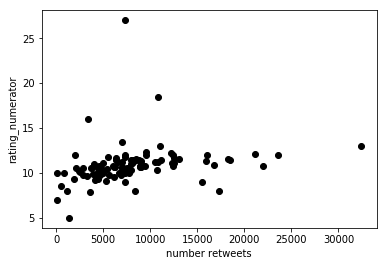

In [58]:
#plot scatter plot of retweets vs rating numerator
plt.plot(x, y, 'o', color='black')
plt.xlabel('number retweets')
plt.ylabel('rating_numerator');

In [72]:
#get only dogs with more than 1 picture
a = twarchive_clean[twarchive_clean['p1_dog'] == True].p1.value_counts()
b = a[a>1].index



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_type,retweet_count,favorite_count,p1,p1_conf,p1_dog
0,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,null,4328,25461,chihuahua,0.716012,True
2,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,null,9774,41048,basset,0.555712,True
3,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,http://twitter.com/download/iphone,Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,null,3261,20562,chesapeake_bay_retriever,0.425595,True
4,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,http://twitter.com/download/iphone,When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,null,16716,56848,pomeranian,0.566142,True
5,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,http://twitter.com/download/iphone,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,null,4429,28226,irish_terrier,0.487574,True
6,890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,http://twitter.com/download/iphone,This is Koda. He is a South Australian decksha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,null,7624,31166,samoyed,0.957979,True
7,889638837579907072,NaN,NaN,2017-07-25 00:10:02 +0000,http://twitter.com/download/iphone,This is Ted. He does his best. Sometimes that'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889638837...,12,10,Ted,null,4735,27672,french_bulldog,0.991650,True
8,889278841981685760,NaN,NaN,2017-07-24 00:19:32 +0000,http://twitter.com/download/iphone,This is Oliver. You're witnessing one of his m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889278841...,13,10,Oliver,null,5637,25652,whippet,0.626152,True
9,888917238123831296,NaN,NaN,2017-07-23 00:22:39 +0000,http://twitter.com/download/iphone,This is Jim. He found a fren. Taught him how t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/888917238...,12,10,Jim,null,4709,29611,golden_retriever,0.714719,True
10,888554962724278272,NaN,NaN,2017-07-22 00:23:06 +0000,http://twitter.com/download/iphone,This is Ralphus. He's powering up. Attempting ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/888554962...,13,10,Ralphus,null,3732,20290,siberian_husky,0.700377,True


In [77]:
y2 = twarchive_clean[twarchive_clean['p1'].isin(b)][twarchive_clean['p1_dog'] == True].groupby('p1').mean().rating_numerator
x2 = twarchive_clean[twarchive_clean['p1'].isin(b)][twarchive_clean['p1_dog'] == True].groupby('p1').mean().favorite_count

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


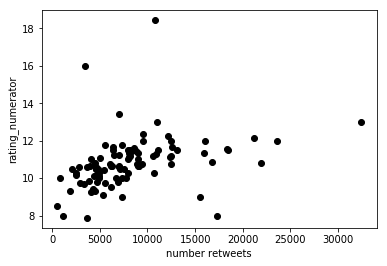

In [78]:
plt.plot(x2, y2, 'o', color='black')
plt.xlabel('number retweets')
plt.ylabel('rating_numerator');